# Week 1 - Tasks

- **Data Source:** `yfinance`
- **Assets:** `AAPL`, `MSFT`, `GOOG`, `AMZN`, `TSLA` (and `NVDA` for Task 5)
- **Timeframes:**
  * **Long Term:** `start="2015-01-01", end="2024-01-01"`
  * **Medium Term:** `start="2020-01-01", end="2024-01-01"` (Includes COVID crash)

The goal for this week is to gain familiarity with financial data, analyze common trends, learn standard library functions, and touch upon the underlying theory.

In [151]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use("seaborn-v0_8-talk")
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.edgecolor"] = "0.3"
plt.rcParams["axes.linewidth"] = 0.8


## Task 1 - Setup
* Fetch **Long Term** historical data for the 5 assets.
* Extract the `Adjusted Close` values.
    * *Note: Check for missing values or empty rows and handle them (drop or fill).*
* Use `df.describe()` to extract key summary statistics.
* Extract the **Medium Term** data as well for later tasks.

In [152]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
start_long = "2015-01-01"
start_med = "2020-01-01"
end_date = "2024-01-01"


In [153]:
data = yf.download(tickers, start=start_long, end=end_date, auto_adjust=False)
adj_close = data['Adj Close']
full_range = pd.date_range(adj_close.index.min(), adj_close.index.max(), freq="B")
adj_close_full = adj_close.reindex(full_range).ffill().bfill()
adj_close = adj_close_full


[*********************100%***********************]  5 of 5 completed


In [154]:
print(adj_close.describe())


Ticker         AAPL         AMZN         GOOG         MSFT         TSLA
count   2346.000000  2346.000000  2346.000000  2346.000000  2346.000000
mean      81.399144    91.897109    73.044962   154.530903   102.871180
std       56.009808    48.624441    36.272358    99.667907   110.946343
min       20.604073    14.347500    24.377235    34.437160     9.578000
25%       32.795019    44.256876    41.486721    59.179604    16.668833
50%       51.187677    90.668247    59.376661   127.528809    23.160666
75%      138.766651   133.200001   104.143904   243.450867   214.390003
max      196.256577   186.570496   149.587082   377.077850   409.970001


In [155]:
df_long = adj_close
df_med = adj_close.loc[start_med:end_date]


## Task 2 - Basic Trends
* Select **one asset** and using the **Medium Term** data, compute:
    * **Returns:** 1-day, 5-day, and 20-day simple returns.
    * **Log Returns:** 1-day, 5-day, and 20-day log returns.
    * **Volatility:** 5-day, 20-day, and 60-day rolling standard deviation (volatility) of the log returns.
* **Plotting:**
    * Plot the price and the 20-day moving average on one chart.
    * Plot the 1-day log returns on a separate chart.
    * Plot the rolling volatilities on a third chart.
    * *Analysis:* What trends do you observe? Does high volatility correlate with price drops?

* **Bonus (Long Term Data):**
    * Create a scatter plot of `|Daily Return|` vs `Volume`. Is there a relationship?
    * Group returns and volatility by **Month** (e.g., all Januaries, all Februaries) and plot the averages. Is there a "seasonal" effect?

In [156]:
# Taking apple (AAPL)
asset = 'AAPL'
price = df_med[asset]


In [157]:
# Calculating ret, logret and vol
ret_1d = price.pct_change().dropna()
ret_5d = price.pct_change(5).dropna()
ret_20d = price.pct_change(20).dropna()

log_ret_1d = np.log(price/price.shift(1)).dropna()
log_ret_5d = np.log(price/price.shift(5)).dropna()
log_ret_20d = np.log(price/price.shift(20)).dropna()

vol_5d = log_ret_1d.rolling(window=5).std().dropna()
vol_20d = log_ret_1d.rolling(window=20).std().dropna()
vol_60d = log_ret_1d.rolling(window=60).std().dropna()


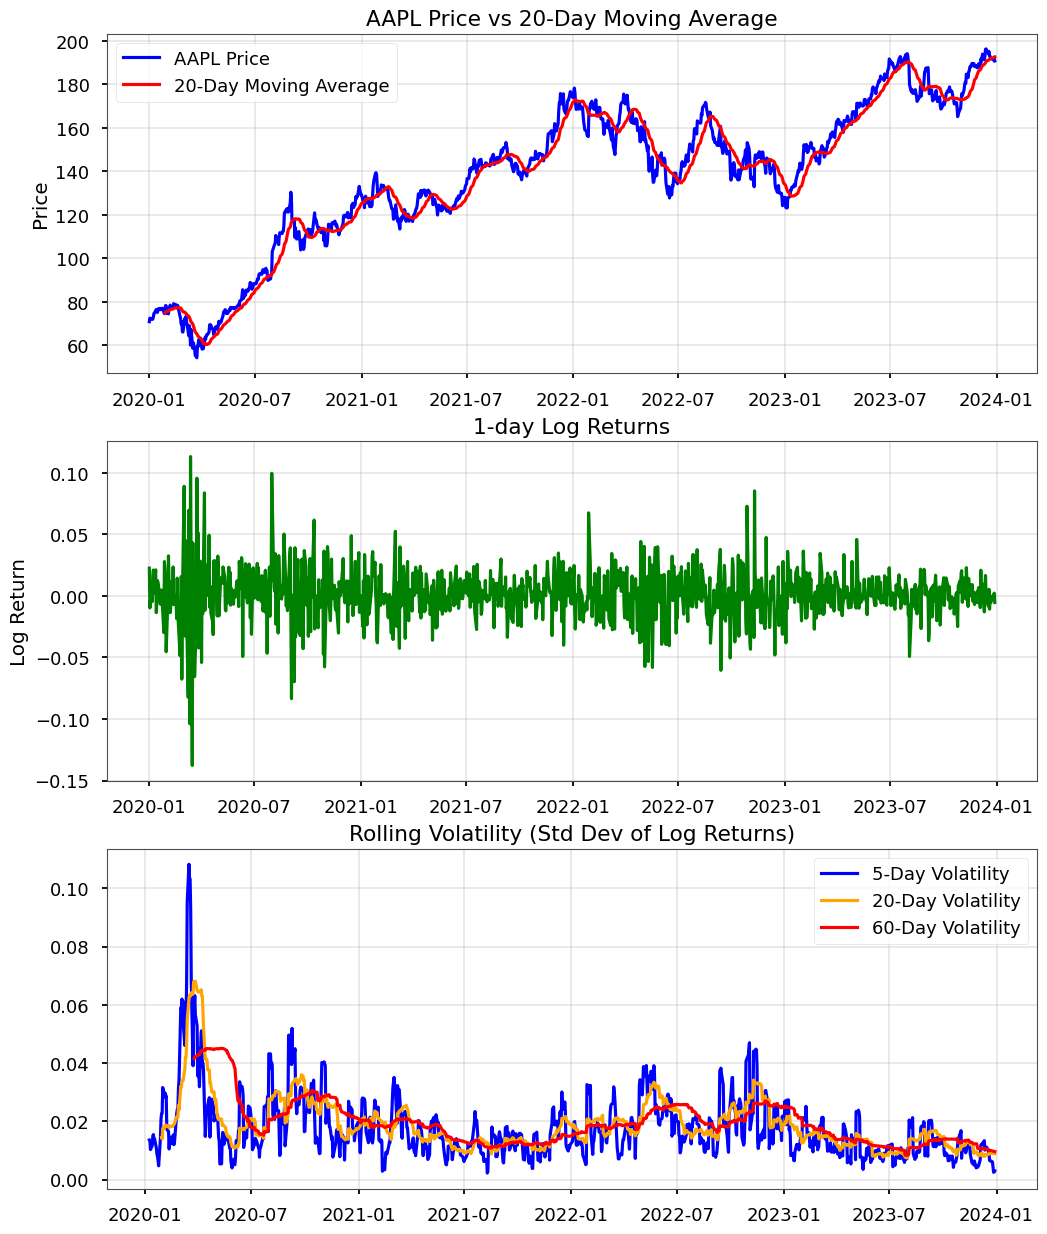

In [158]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

axes[0].plot(price, label=f'{asset} Price', color='blue')
axes[0].plot(price.rolling(20).mean(), label='20-Day Moving Average', color='red')
axes[0].set_title(f'{asset} Price vs 20-Day Moving Average')
axes[0].set_ylabel('Price')
axes[0].legend()

axes[1].plot(log_ret_1d, color='green')
axes[1].set_title('1-day Log Returns')
axes[1].set_ylabel('Log Return')

axes[2].plot(vol_5d, label='5-Day Volatility', color='blue')
axes[2].plot(vol_20d, label='20-Day Volatility', color='orange')
axes[2].plot(vol_60d, label='60-Day Volatility', color='red')
axes[2].set_title('Rolling Volatility (Std Dev of Log Returns)')
axes[2].legend()

# Does high volatility correlate with price drops?

# Yes, price drops are generally correlated with high volatility in the above plots
# This may be due to bad news which causes panic selling which in turn leads to increased variance in returns


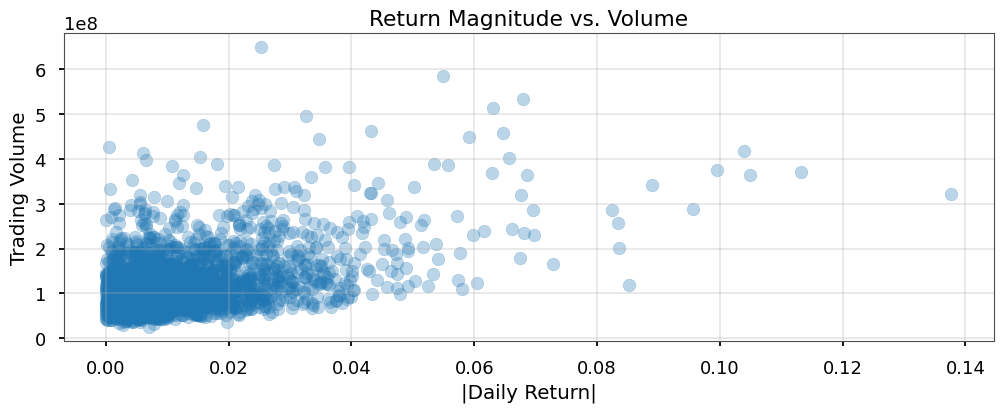

In [159]:
logret_long = np.log(data['Adj Close'][asset] / data['Adj Close'][asset].shift(1)).dropna()
volume = data['Volume'][asset].loc[logret_long.index]
plt.scatter(logret_long.abs(), volume, alpha=0.3)
plt.xlabel('|Daily Return|')
plt.ylabel('Trading Volume')
plt.title('Return Magnitude vs. Volume')
plt.show()

# They appear to be positively correlated from the plot


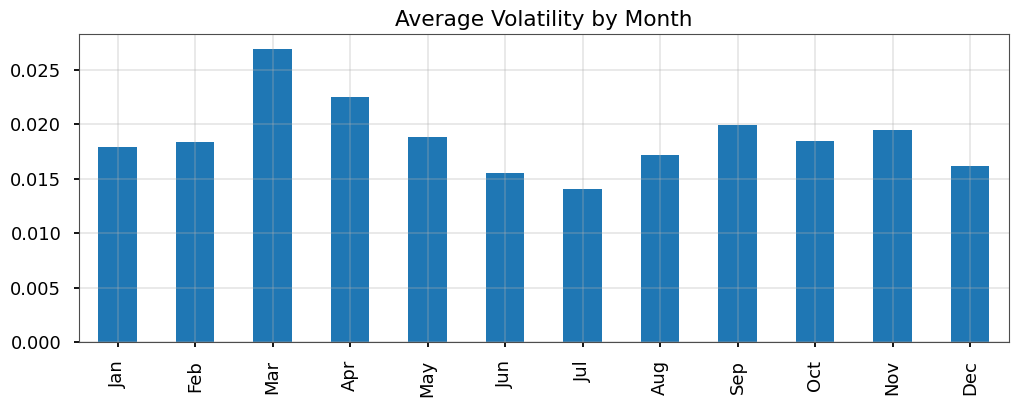

In [160]:
monthly_avg_vol = vol_20d.groupby(vol_20d.index.month).mean()
monthly_avg_vol.plot(kind='bar')
plt.title('Average Volatility by Month')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


## Task 3 - Stationarity
* Select **one asset** (Long Term).
* Compute the **Rolling Mean** and **Rolling Standard Deviation** of log returns with window sizes `20, 60, 120`.
* Plot them and visually inspect.
    * Does the mean stay constant? (Stationary mean)
    * Does the variance stay constant? (Stationary variance)
* Run an **Augmented Dickey-Fuller (ADF) Test** on the log return series.
    * Library: `from statsmodels.tsa.stattools import adfuller`
    * *Goal:* Interpret the p-value. The Null Hypothesis ($H_0$) is that the series is non-stationary (has a unit root). If p-value < 0.05, we reject $H_0$.
    * For learning about hypothesis testing and p-value you can refer to CS215 slides or other standard resources mentioned in READMEs.

In [161]:
# Taking Apple (AAPL) again
returns = log_ret_1d

mean_20 = returns.rolling(window=20).mean()
mean_60 = returns.rolling(window=60).mean()
mean_120 = returns.rolling(window=120).mean()

std_20 = returns.rolling(window=20).std()
std_60 = returns.rolling(window=60).std()
std_120 = returns.rolling(window=120).std()


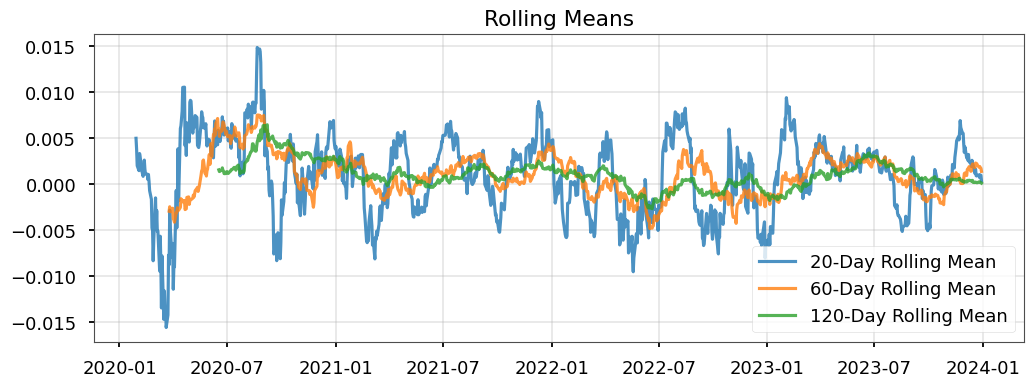

In [162]:
plt.plot(mean_20, label='20-Day Rolling Mean', alpha=0.8)
plt.plot(mean_60, label='60-Day Rolling Mean', alpha=0.8)
plt.plot(mean_120, label='120-Day Rolling Mean', alpha=0.8)
plt.title('Rolling Means')
plt.legend()
plt.show()

# While there are small fluctuations, the mean does not show a persistent upward or downward trend


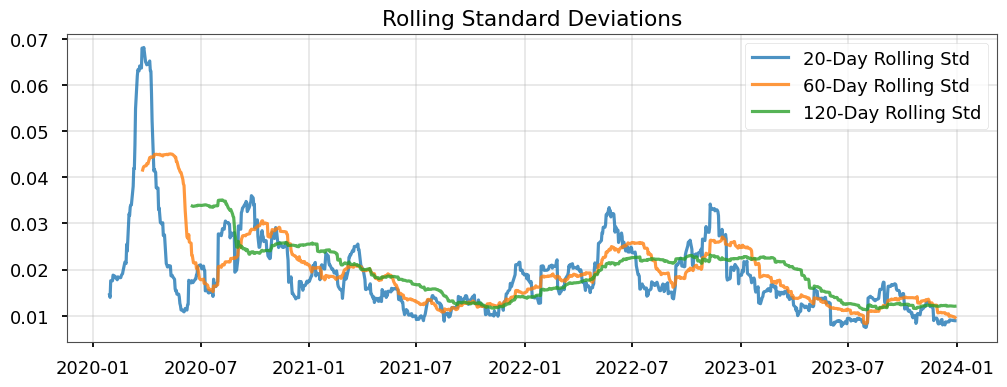

In [163]:
plt.plot(std_20, label='20-Day Rolling Std', alpha=0.8)
plt.plot(std_60, label='60-Day Rolling Std', alpha=0.8)
plt.plot(std_120, label='120-Day Rolling Std', alpha=0.8)
plt.title('Rolling Standard Deviations')
plt.legend()
plt.show()

# The variance (volatility) changes significantly over time


In [164]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(returns)
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("Reject H0: Stationary.")
else:
    print("Fail to reject H0: Non-stationary.")


p-value: 7.633166414348627e-18
Reject H0: Stationary.


## Task 4 - Volatility Regimes
We try to study the trend in volatility more deeply. From the ACF/PACF plot we know that volatility tends to cluster that is the market is either in a high volatility state (greater daily fluctuations) or low volatility state (stable prices, quiet markets).

Formally we can treat volatility as a *conditional standard deviation of returns*, conditioned on the history observed so far. We *cannot* predict *true* volatility for a given day based on the single return value, hence we try to estimate it using the past information. For this we look at two indicators of volatility:

1.  **Rolling Window Volatility:** Simple Moving Average (SMA) of standard deviation.
2.  **EWMA Volatility:** Exponentially Weighted Moving Average. This gives more weight to recent events. It is given by $\sigma_t^2 = (1-\lambda)r_t^2 + \lambda \sigma_{t-1}^2$.

**Steps:**
* Pick an asset and use data covering the **Feb-Mar 2020 COVID crash**.
* Compute two volatility estimates on the Log Returns:
    1.  **Rolling 20-day Volatility:** Standard deviation over a 20-day window.
    2.  **EWMA Volatility (RiskMetrics):** Use a decay factor $\lambda = 0.94$.
        * *Hint:* In pandas `df.ewm()`, the parameter `alpha` corresponds to $1 - \lambda$. So, use `alpha=0.06`.
* **Analysis:**
    * Plot both estimates on the same chart.
    * Which is smoother?
    * Which estimator reacts faster to the sudden crash in March 2020?
    * Which one would you prefer for risk management?
* **Regime Detection:** Compute the 60th percentile of your EWMA volatility series. Shade the regions on the plot where volatility exceeds this level.

* **Bonus:** A good volatility model "standardizes" the returns well. Calculate $z_t = r_t / \hat{\sigma}_t$. If the model is good, $z_t$ should have $Var \approx 1$. Check the variance of $z_t$ and plot its histogram.

In [165]:
returns_t4 = returns.loc['2020-01-01':'2020-06-01']
vol_rolling = returns_t4.rolling(window=20).std()
vol_ewma = np.sqrt((returns_t4**2).ewm(alpha=0.06).mean())


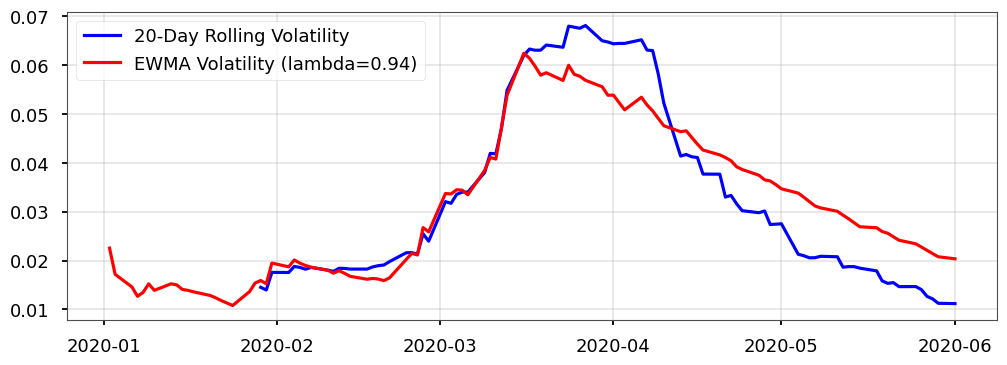

In [166]:
plt.plot(vol_rolling, label='20-Day Rolling Volatility', color='blue')
plt.plot(vol_ewma, label='EWMA Volatility (lambda=0.94)', color='red')
plt.legend()
plt.show()

# The rolling 20-day volatility is smoother compared to EWMA volatility
# EWMA reacts faster to the crash. Hence, it is preferred for risk management


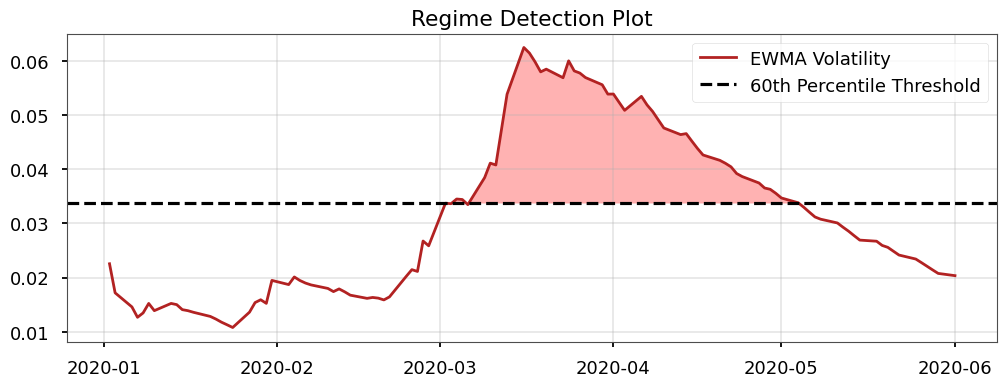

In [167]:
threshold = vol_ewma.quantile(0.60)
plt.plot(vol_ewma, label='EWMA Volatility', color='firebrick', lw=2)
plt.axhline(threshold, color='black', linestyle='--', label='60th Percentile Threshold')
plt.fill_between(vol_ewma.index, threshold, vol_ewma, where=(vol_ewma > threshold), color='red', alpha=0.3, interpolate=True)
plt.title('Regime Detection Plot')
plt.legend()
plt.show()


Variance of standardized returns: 0.9589


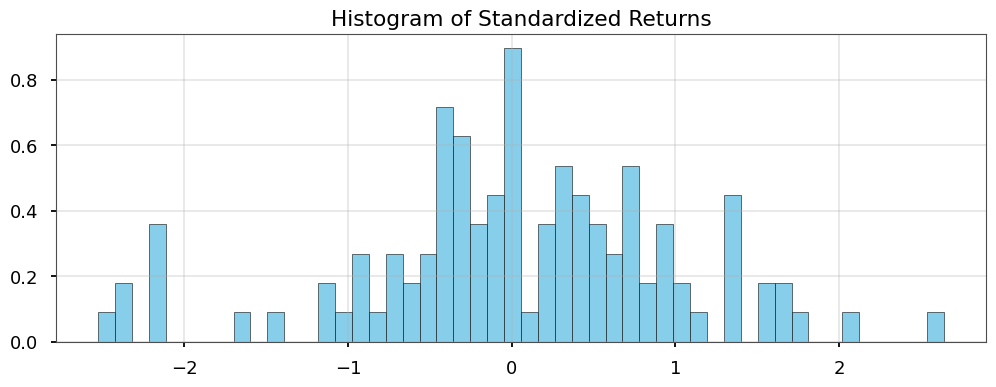

In [168]:
# Bonus
z_t = log_ret_1d / vol_ewma
variance_zt = z_t.var()
print(f"Variance of standardized returns: {variance_zt:.4f}")
plt.hist(z_t.dropna(), bins=50, density=True, color='skyblue', edgecolor='black')
plt.title('Histogram of Standardized Returns')
plt.show()

# Variance comes out to be approx 1


## Task 5 - Time Horizons and the "Normal" Illusion
Short-term markets are noisy and dangerous (fat tails), while long-term data looks smoother. We can prove this statistically using **Skew** and **Kurtosis**.

**Theory:**
* **Skewness:** Measures asymmetry. (Negative skew = frequent small gains, few extreme losses).
* **Kurtosis:** Measures "tailedness". (High kurtosis = frequent extreme events/crashes).
* **Normal Distribution:** Skew $\approx 0$, Kurtosis $\approx 3$ (or Excess Kurtosis $\approx 0$).

**Steps:**
1.  Take your **Long Term** data for one asset (e.g., NVDA or TSLA).
2.  Resample the prices to get **Weekly** and **Monthly** closes.
    * Use `df['Adj Close'].resample('W').last()` and `...resample('M').last()`.
3.  Compute Log Returns for all three series: Daily, Weekly, Monthly.
4.  **The Test:**
    * Calculate **Skew** and **Kurtosis** for each of the three return series.
    * *Question:* How do these values change as the time horizon increases? Do they get closer to 0 and 3?
5.  **Visualization:**
    * Plot the **Histograms** of the Daily returns vs. Monthly returns on the same plot.
    * *Tip:* You will need to standardize them (subtract mean, divide by std dev) to overlay them meaningfully.
    * *Observation:* Look at the tails. Which one has "fatter" tails (more extreme outliers)?

**Key Takeaway:**
Daily returns often violate the "Normal Distribution" assumption used in many financial models. Long-term returns fit it better. This is called *Aggregational Gaussianity*.

**Bonus:** This is a direct application of a simple yet well-known result in asymptotic statistics. Can you find out what it is and state how it explains this observation?

In [169]:
from scipy.stats import skew, kurtosis

# Apple (AAPL) again
asset_price = df_long['AAPL']
price_weekly = asset_price.resample('W').last()
price_monthly = asset_price.resample('M').last()

log_ret_daily = np.log(asset_price / asset_price.shift(1)).dropna()
log_ret_weekly = np.log(price_weekly / price_weekly.shift(1)).dropna()
log_ret_monthly = np.log(price_monthly / price_monthly.shift(1)).dropna()


/var/folders/xx/3fw5f3lj3w3g7lx4bwlmn4980000gn/T/ipykernel_14902/2090458856.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_monthly = asset_price.resample('M').last()


In [170]:
for name, data in [("Daily", log_ret_daily), ("Weekly", log_ret_weekly), ("Monthly", log_ret_monthly)]:
    print(f"{name} : Skew = {skew(data)}, Kurtosis = {kurtosis(data, fisher=False)}")

# Do they get closer to 0 and 3?
# Skew : Generally yes, because returns should become more symmetric as we move from daily to weekly to monthly
# Kurtosis : Yes, as the horizon increases to monthly, the value becomes very close to the gaussian value of 3


Daily : Skew = -0.22485760869542326, Kurtosis = 8.702203390819232
Weekly : Skew = -0.38864101089962394, Kurtosis = 5.268281820160497
Monthly : Skew = -0.2418876408928549, Kurtosis = 2.514035308026274


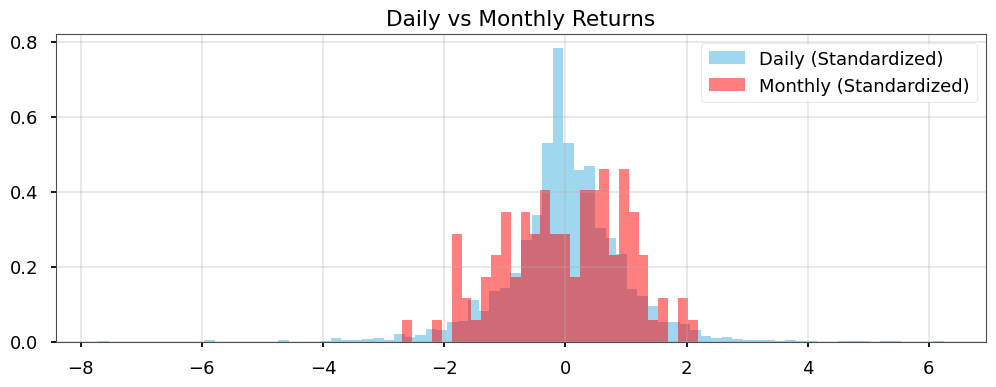

In [171]:
def standardize(s):
    return (s - s.mean()) / s.std()

plt.hist(standardize(log_ret_daily), bins=80, alpha=0.8, label='Daily (Standardized)', density=True, color='skyblue')
plt.hist(standardize(log_ret_monthly), bins=30, alpha=0.5, label='Monthly (Standardized)', density=True, color='red')
plt.title('Daily vs Monthly Returns')
plt.legend()
plt.show()

# The daily returns have a higher peak and fatter tails compared to the monthly returns
# The reason for this is the Central Limit Theorem (CLT)


## Task 6 - Smart investing
Calculate how many **RTX 4090s** (approx. price $1,600$) you could afford *today* if you had invested **$1,000** in NVIDIA on the day you were born.

In [173]:
birth_date = "2007-04-03"
ticker = "NVDA"
data = yf.download(ticker, start=birth_date, auto_adjust=False)
adj_close = data['Adj Close']
p_birth = adj_close.iloc[0].item()
p_today = adj_close.iloc[-1].item()
investment = 1000
current_value = (p_today / p_birth) * investment
rtx_count = current_value / 1600
print(f"Price on birth date: ${p_birth:.2f}")
print(f"Price today: ${p_today:.2f}")
print(f"Value of $1,000 investment: ${current_value:,.2f}")
print(f"Number of RTX 4090s I can afford: {int(rtx_count)}")


[*********************100%***********************]  1 of 1 completed

Price on birth date: $0.44
Price today: $180.99
Value of $1,000 investment: $413,563.54
Number of RTX 4090s I can afford: 258
